In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
start_time = time.time()

In [2]:
def data_preprocess(data_path:str)->pd.DataFrame:
    """
    数据预处理
    :param data_path: 数据路径
    :return: 处理后的数据
    """
    data_raw = pd.read_csv(data_path)   # 读取数据
    data_raw = data_raw.iloc[:, :3] # 去掉时间戳
    data_raw = data_raw.sample(frac=1, random_state=42) # 打乱数据
    return data_raw

In [3]:
data_raw = data_preprocess("ratings.csv")

In [4]:
data_raw

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


In [5]:
def get_data_dict(data:list[list])->dict[int, dict[int, float]]:
    """
    获取数据矩阵
    :param data: 数据
    :return: 数据矩阵
    """
    
    data_dict = {}
    for record in data:
        user = int(record[0])   # 用户名
        movie = int(record[1])  # 电影
        rating = record[2]      # 评分
        if user not in data_dict:
            data_dict[user] = {movie: rating}
        else:
            data_dict[user][movie] = rating
    return data_dict

In [6]:
def k_folds(data:pd.DataFrame, k=10) -> tuple[dict[int, dict[int, float]], dict[int, dict[int, float]]]:
    """
    k折交叉验证
    :param data: 数据
    :param k: 折数
    :return: 训练集和验证集
    """
    data = data.values.tolist()
    each_fold_size = len(data) // k  # 每折的长度
    for i in range(k):
        # 根据循环次数划分不同的训练集和测试集
        if i == k - 1:
            valid = data[i * each_fold_size:]
            train = data[:i * each_fold_size]
        elif i == 0:
            valid = data[: (i + 1) * each_fold_size]
            train = data[(i + 1) * each_fold_size:]
        else:
            valid = data[i * each_fold_size: (i + 1) * each_fold_size]
            train = data[: i * each_fold_size] + data[(i + 1) * each_fold_size :]

        # print(f"第{i+1}折: 训练集长度为{len(train)}, 验证集长度为{len(valid)}")
        yield get_data_dict(train), get_data_dict(valid)

In [7]:
# print(" train_len   valid_len")
for train_matrix, val_matrix in k_folds(data_raw):
    print(len(train_matrix.keys()), len(val_matrix.keys()))

610 603
610 601
610 589
610 602
610 596
610 596
610 601
610 600
610 595
610 600


### 计算皮尔逊系数
![Pearson](PCC.png)

In [8]:
def Pearson(ratings1:list[float], ratings2:list[float]) -> float:
    """
    计算皮尔逊相关系数
    :param ratings1: 用户1的评分
    :param ratings2: 用户2的评分
    :return: 皮尔逊相关系数
    """
    numerator = 0
    denominator1 = 0
    denominator2 = 0
    mean1 = sum(ratings1) / len(ratings1)
    mean2 = sum(ratings2) / len(ratings2)
    for rating1, rating2 in zip(ratings1, ratings2):
        temp1 = rating1 - mean1
        temp2 = rating2 - mean2
        numerator += temp1 * temp2
        denominator1 += temp1 ** 2
        denominator2 += temp2 ** 2
    denominator = (denominator1 * denominator2) ** 0.5
    return numerator / denominator if denominator != 0 else None

### Cosine相似度
![Cosine](Cosine.png)

In [9]:
def Cosine(ratings1:list[float], ratings2:list[float]) -> float:
    """
    计算余弦相似度
    :param ratings1: 用户1的评分
    :param ratings2: 用户2的评分
    :return: 余弦相似度
    """
    numerator = 0
    denominator1 = 0
    denominator2 = 0
    for rating1, rating2 in zip(ratings1, ratings2):
        numerator += rating1 * rating2
        denominator1 += rating1 ** 2
        denominator2 += rating2 ** 2
    denominator = (denominator1 * denominator2) ** 0.5
    return numerator / denominator if denominator != 0 else None

### Slope One Distance
![slope-one](slope-one-distance.png)

In [10]:
def Slope_One_Distance(ratings1:list[float], ratings2:list[float])->float:
    """
    计算slope one距离
    :param ratings1: 用户1的评分
    :param ratings2: 用户2的评分
    :return: slope one距离
    """
    numerator = 0
    denominator = len(ratings1)
    for rating1, rating2 in zip(ratings1, ratings2):
        numerator += rating1 - rating2
    return numerator / denominator if denominator != 0 else None

In [11]:
from typing import Callable
def calculate_similarity(train_dict:dict, sim_func:Callable=Pearson)->dict:
    """
    计算相似度
    :param train_dict: 训练集
    :param sim_func: 计算相似度的方法
    :return 用户相似度字典
    """
    similarity_dict = {}

    for user1 in train_dict.keys():
        for user2 in train_dict.keys():
            if user1 <= user2:  # 只计算上三角
                continue
            # 计算两个用户评价过的物品交集
            intersection_movies = set(train_dict[user1].keys()) & set(train_dict[user2].keys())
            # 如果交集为空，跳过
            if len(intersection_movies) == 0:
                continue

            ratings1 = [train_dict[user1][movie] for movie in intersection_movies]
            ratings2 = [train_dict[user2][movie] for movie in intersection_movies]

            sim = sim_func(ratings1, ratings2)
            if sim is None:
                continue

            # 如果使用Pearson或Cosine相似度，矩阵是对称的
            similarity_dict.setdefault(user1, {})[user2] = sim
            
            # 如果是slope one距离，use1和user2 与 user2和user1 是相反数
            if sim_func.__name__ == "Slope_One_Distance":
                sim = -sim

            similarity_dict.setdefault(user2, {})[user1] = sim

    return similarity_dict

In [12]:
for train_dict, val_dict in k_folds(data_raw):
    similarity_dict = calculate_similarity(train_dict, sim_func=Slope_One_Distance)
    break

In [13]:
similarity_dict[1]

{479: 0.8333333333333334,
 91: 0.5108695652173914,
 292: 0.9732142857142857,
 474: 0.9609375,
 124: 0.5,
 605: 1.03125,
 21: 0.5,
 542: 0.4444444444444444,
 453: 0.328125,
 159: 1.2,
 109: 0.782608695652174,
 51: 0.9090909090909091,
 590: 0.8523809523809524,
 153: 2.1875,
 599: 0.986013986013986,
 509: 1.2166666666666666,
 263: 0.6166666666666667,
 514: 0.6413043478260869,
 365: 1.7916666666666667,
 580: 0.5390625,
 166: 0.5357142857142857,
 182: 0.7616822429906542,
 376: 0.3333333333333333,
 332: 0.6607142857142857,
 233: 0.6818181818181818,
 28: 1.3135593220338984,
 217: 1.2574257425742574,
 384: 0.4166666666666667,
 313: 0.8214285714285714,
 368: 1.0232558139534884,
 186: 0.15217391304347827,
 410: 1.0526315789473684,
 577: 0.803921568627451,
 249: 0.2986111111111111,
 246: 0.675,
 393: 0.8461538461538461,
 409: 0.5,
 18: 0.55,
 561: 0.5740740740740741,
 89: 2.8461538461538463,
 359: 0.8125,
 555: 0.2682926829268293,
 169: 0.22727272727272727,
 232: 0.6477272727272727,
 298: 1.22131

### 获取潜在相邻用户

In [14]:
def sort_neighbor(similarity_dict:dict, sim_func:Callable)->dict:
    """
    对相似度字典进行排序
    :param similarity_dict: 相似度字典
    :return: 排序后的相似度字典
    """
    if sim_func.__name__ == "Slope_One_Distance":   # 如果是slope one，不需要排序
        return {user: list(sim_dict.keys()) for user, sim_dict in similarity_dict.items()}
    
    neighbor_dict = {}
    for user, sim_dict in similarity_dict.items():
        neighbor_dict[user] = [user for user, _ in sorted(sim_dict.items(), key=lambda x: x[1], reverse=True)]
    return neighbor_dict
    

In [15]:
neighbor_dict = sort_neighbor(similarity_dict, sim_func=Slope_One_Distance)

In [16]:
neighbor_dict[1]

[479,
 91,
 292,
 474,
 124,
 605,
 21,
 542,
 453,
 159,
 109,
 51,
 590,
 153,
 599,
 509,
 263,
 514,
 365,
 580,
 166,
 182,
 376,
 332,
 233,
 28,
 217,
 384,
 313,
 368,
 186,
 410,
 577,
 249,
 246,
 393,
 409,
 18,
 561,
 89,
 359,
 555,
 169,
 232,
 298,
 52,
 438,
 223,
 381,
 603,
 414,
 354,
 222,
 156,
 344,
 202,
 113,
 606,
 274,
 435,
 66,
 434,
 387,
 448,
 517,
 570,
 607,
 140,
 72,
 162,
 212,
 279,
 62,
 353,
 380,
 105,
 220,
 525,
 240,
 152,
 129,
 160,
 370,
 199,
 598,
 541,
 68,
 505,
 469,
 452,
 600,
 132,
 470,
 307,
 312,
 524,
 271,
 40,
 480,
 567,
 19,
 596,
 443,
 610,
 244,
 161,
 234,
 226,
 26,
 201,
 522,
 20,
 401,
 43,
 310,
 177,
 483,
 546,
 559,
 352,
 13,
 528,
 83,
 444,
 137,
 176,
 200,
 3,
 489,
 11,
 500,
 305,
 221,
 563,
 501,
 171,
 288,
 579,
 425,
 15,
 213,
 318,
 523,
 573,
 136,
 362,
 543,
 534,
 372,
 396,
 179,
 241,
 608,
 254,
 369,
 429,
 225,
 602,
 475,
 216,
 419,
 260,
 385,
 158,
 195,
 17,
 80,
 64,
 4,
 265,
 231,
 

### 计算训练集中每个用户的平均分

In [17]:
def avg(train_dict:dict)->dict[int, float]:
    """
    计算每个用户的平均评分
    :param train_dict: 训练集
    :return: 用户的平均评分
    """
    avg_dict = {}
    for user, movie_dict in train_dict.items():
        avg_dict[user] = sum(movie_dict.values()) / len(movie_dict)
    return avg_dict

In [18]:
avg_dict = avg(train_dict)

In [19]:
avg_dict[1]

4.333333333333333

### 预测评分
![predict](predict.png)
### slope one预测
![slope one predict](slope-one-predict.png)

In [20]:
from typing import Optional
def predict(train_dict:dict, val_dict:dict,
            similarity_dict:dict, avg_dict:dict, 
            neighbor_dict:dict, neighbor_num:Optional[int]=None,
            sim_func:Callable=Pearson)->dict[int, dict[int, float]]:
    """
    预测评分
    :param train_dict: 训练集 {user: {movie: rating}
    :param val_dict: 验证集 {user: {movie: rating}
    :param similarity_dict: 相似度字典 {user1: {user2: sim}
    :param neighbor_dict: 排序后的相似度字典 {user: [neighbor1, neighbor2, ...]}
    :param avg_dict: 用户的平均评分 {user: avg}
    :param neighbor_num: 邻居数量,当sim_func为slope one时, 不使用
    :sim_func: 相似度计算方法
    :return: 预测评分
    """

    predict_dict = {}
    for user in val_dict.keys():
        to_predict_movies = val_dict[user].keys()   # 需要预测的电影

        # 如果用户不在训练集中，预测为3.5, 作为默认值
        if user not in train_dict.keys():
            predict_dict[user] = {movie: 3.5 for movie in to_predict_movies}
            continue
        # 如果用户没有邻居，取平均值作为预测值
        if user not in neighbor_dict.keys():
            predict_dict[user] = {movie: avg_dict[user] for movie in to_predict_movies}
            continue

        neighbors = neighbor_dict[user] # 用户的邻居
        # 遍历需要预测的电影
        for movie in to_predict_movies:
            numerator = 0
            denominator = 0
            neighbors_now = 0   # 记录当前使用的相邻用户的个数

            # 遍历邻居
            for neighbor in neighbors:
                # 如果邻居没有看过该电影，跳过
                if movie not in train_dict[neighbor].keys():
                    continue
                
                neighbors_now += 1  
                
                if sim_func==Slope_One_Distance:    # 如果使用slope one
                    numerator += train_dict[neighbor][movie] + similarity_dict[user][neighbor]
                else:   # 如果不使用slope one
                    numerator += similarity_dict[user][neighbor] * (train_dict[neighbor][movie] - avg_dict[neighbor])
                    denominator += abs(similarity_dict[user][neighbor])
                    # 如果已使用的邻居数量已达到要求，则跳出循环
                    if neighbors_now >= neighbor_num:
                        break
            
            if sim_func==Slope_One_Distance:    # 如果使用slope one
                predict_rating = numerator / neighbors_now if neighbors_now != 0 else avg_dict[user]
            else:   # 如果不使用slope one
                predict_rating = avg_dict[user] + numerator / denominator if denominator != 0 else avg_dict[user]

            predict_dict.setdefault(user, {})[movie] = predict_rating

    return predict_dict

In [21]:
predict_dict = predict(train_dict, val_dict, similarity_dict, avg_dict, neighbor_dict, sim_func=Slope_One_Distance)
# predict_dict = predict(train_dict, val_dict, similarity_dict, avg_dict, neighbor_dict, neighbor_num=100, is_slope_one=False)

In [22]:
predict_dict[1]

{3740: 4.564050143301628,
 2353: 3.9627300523446722,
 1278: 4.683029220372187,
 596: 4.0874230086253664,
 2115: 4.309575737780212,
 2529: 4.490473027003362,
 1927: 4.6755539688721,
 2078: 4.538233573316528,
 3034: 4.282398212061787,
 2899: 4.257425742574258,
 1500: 4.333077681584756,
 1198: 4.806174893353428,
 1587: 4.011038158191317,
 1029: 4.0615646663096525,
 423: 3.6918154244240364,
 2492: 2.9175471344551056,
 2048: 4.012110892666245,
 2797: 4.348027658468632,
 3578: 4.619475070407013,
 2991: 4.342242831216106,
 1580: 4.104411263434079,
 2640: 4.2687997662263815,
 2387: 3.9200485426760987,
 1954: 4.561339464631571,
 2459: 3.862278362425951}

In [23]:
def MAE(predict_dict:dict[int, dict[int, float]], val_dict:dict[int, dict[int, float]])->float:
    """
    计算MAE
    :param predict_dict: 预测评分
    :param val_dict: 验证集
    :return: MAE
    """
    error = 0
    predict_nums = 0
    for user in val_dict.keys():
        for movie in val_dict[user].keys():
            error += abs(predict_dict[user][movie] - val_dict[user][movie])
            predict_nums += 1
    return error / predict_nums

In [24]:
MAE(predict_dict, val_dict)

0.6751634635472472

# 完整流程(Slope One)

In [31]:
def user_based_CF(data_path:str, fold_num:int,neighbor_num:Optional[int]=None, sim_func:Callable=Pearson, log:bool=True)->float:
    """
    基于用户的协同过滤
    :param data_path: 数据路径
    :param fold_num: 折数
    :param neighbor_num: 邻居数量, 可选, 当使用slope one时, 不使用
    :param sim_func: 相似度计算方法, Pearson, Cosine, Slope One
    :param log: 是否打印日志
    """
    data_raw = data_preprocess(data_path)

    assert sim_func != Slope_One_Distance or neighbor_num == None, "使用Slope One时，不应有neighbor_num"

    MAE_list = []
    for i, (train_dict, val_dict) in enumerate(k_folds(data_raw, fold_num)):
        # 计算相似度
        similarity_dict = calculate_similarity(train_dict, sim_func=sim_func)
        # 计算每个用户的平均评分
        avg_dict = avg(train_dict)
        # 对相似度字典进行排序
        neighbor_dict = sort_neighbor(similarity_dict, sim_func=sim_func)
        # 预测评分
        predict_dict = predict(train_dict, val_dict, 
                               similarity_dict, avg_dict, neighbor_dict, 
                               neighbor_num=neighbor_num, sim_func=sim_func)
        
        MAE_list.append(MAE(predict_dict, val_dict))
        if log:
            print(f"第{i+1}折  MAE: {MAE_list[-1]}")
    
    return sum(MAE_list) / len(MAE_list)

In [32]:
print(Slope_One_Distance.__name__)
mae = user_based_CF("ratings.csv", fold_num=10, sim_func=Slope_One_Distance, log=True)
# mae = user_based_CF("ratings.csv", fold_num=10, sim_func=Pearson, neighbor_num=100, log=True)
# mae = user_based_CF("ratings.csv", fold_num=10, sim_func=Cosine, neighbor_num=100, log=True)
print(mae)

Slope_One_Distance
第1折  MAE: 0.6751634635472472
第2折  MAE: 0.663599427407806
第3折  MAE: 0.6594199502473619
第4折  MAE: 0.6679740797036291
第5折  MAE: 0.670381741368829
第6折  MAE: 0.6561442732177161
第7折  MAE: 0.6620806412532537
第8折  MAE: 0.6621856933059518
第9折  MAE: 0.6691297339127668
第10折  MAE: 0.6731609591824909
0.6659239963147053


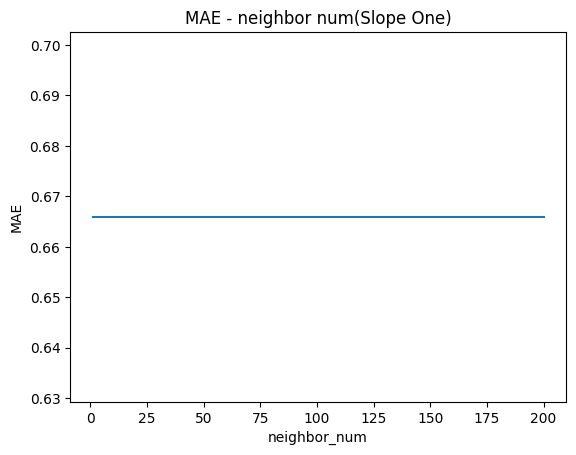

In [28]:
neighbor_nums = [i for i in range(1,11)] + [i for i in range(11, 32, 2)] + [i for i in range(35, 201, 5)]
MAE_list = [mae] * len(neighbor_nums)
plt.plot(neighbor_nums, MAE_list)
plt.xlabel("neighbor_num")
plt.ylabel("MAE")
plt.title("MAE - neighbor num(Slope One)")
plt.show()

In [29]:
print(f"运行时间: {time.time() - start_time}s")

运行时间: 46.7773642539978s
